In [1]:
from jax_circuits import*
from topology import *
from penalty import *
import matplotlib.pyplot as plt
from scipy.stats import unitary_group
from qiskit.quantum_info import Operator

# Aux

In [2]:
def random_cp_angles(num_angles, cp_mask, **kwargs):
    return random_angles(num_angles, **kwargs)*(1-cp_mask)

def cp_loss(loss_func, angles, cp_mask, reg=1, h=2, t=1e-3):
    cp_angles = angles*anz.cp_mask
    penalty_loss = cp_penalty_linear(cp_angles, h, t).sum()
    return loss_func(angles)+reg*penalty_loss

def cnot_value(a, threshold=1e-2):
    t=threshold
    a = a % (2*jnp.pi)
    return jnp.piecewise(a, 
                         [a < t, jnp.abs(a-2*jnp.pi)<t, jnp.abs(a-jnp.pi)<t],
                         [0, 0, 1, 2])    

def count_cnots(angles, **kwargs):
    return sum([cnot_value(a, **kwargs) for a in angles])

def plot_cp_angles(angles, h=2, t=1e-2):
    a_sweep = jnp.linspace(0, 2*jnp.pi, 200)
    angles = angles % (2*jnp.pi)
    plt.plot(a_sweep, cp_penalty_linear(a_sweep, h, t))
    plt.scatter(angles, 
                cp_penalty_linear(angles, h, t)+0.1*random.normal(random.PRNGKey(0), (len(angles), )), 
                alpha=0.5)
    
    
def success_rate(anz, u_target, cnot_count, method, learning_rate=0.1, r=0.001, h=2, t=1e-3, num_samples=10):
    success_hist=[]
    best_angles_hist = []
    for k in range(num_samples):
        initial_angles = random_cp_angles(anz.num_angles, anz.cp_mask, key=random.PRNGKey(k))
        angles_hist, loss_hist, disc_hist, penalty_hist = anz.learn(u_target,
                                                                    method=method,
                                                                    learning_rate=learning_rate,                                                                                       
                                                                    cp_penalty=True, 
                                                                    r=r,
                                                                    h=h,
                                                                    t=t,
                                                                    initial_params=initial_angles,
                                                                    num_iterations=1000) 
        best_angles = angles_hist[jnp.argmin(loss_hist)]
        best_angles_hist.append(best_angles)
        if disc_hist[jnp.argmin(loss_hist)]<1e-3 and count_cnots(best_angles*anz.cp_mask, threshold=0.2) <= cnot_count:
            success_hist.append(1)
        else:
            success_hist.append(0)
    
    return best_angles_hist, success_hist

def report_cp_learning(res, cp_mask=None):
    angles_hist, loss_hist, disc_hist, penalty_hist = res
    best_angles = angles_hist[jnp.argmin(loss_hist)]
    
    
    
    if cp_mask is not None:
        best_cp_angles = best_angles*cp_mask
        best_cp_angles = best_cp_angles[best_cp_angles!=0]
        print('cnot count: {}'.format(count_cnots(best_cp_angles, threshold=0.2)))
        print('fidelity at this count: {}'.format(disc_hist[jnp.argmin(loss_hist)]))
    else:
        best_cp_angles = None
    plt.plot(loss_hist, label='loss')
    plt.plot(disc_hist, label='disc')
    plt.plot(penalty_hist, label='penalty')
    plt.yscale('log')
    plt.legend()
    
    return best_angles, best_cp_angles

# Random unitary 2

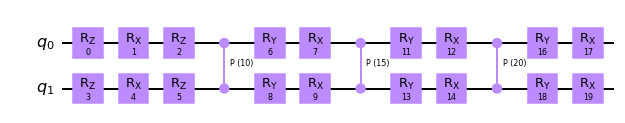

In [2]:
num_qubits = 2
anz = Ansatz(2, 'cp', placements=fill_layers(sequ_layer(num_qubits), 3))
angles = jnp.arange(anz.num_angles, dtype='float32')
u_target = unitary_group.rvs(2**num_qubits, random_state=14)
anz.circuit(angles).draw(output='mpl')

In [4]:
%%time
angles_history_adam, loss_history_adam = anz.learn(u_target, method='adam')

CPU times: user 2.48 s, sys: 7.55 ms, total: 2.49 s
Wall time: 2.47 s


In [5]:
%%time
angles_history_ngd, loss_history_ngd = anz.learn(u_target, method='natural gd')

CPU times: user 5.1 s, sys: 63.7 ms, total: 5.17 s
Wall time: 5.05 s


In [6]:
%%time
angles_history_nadam, loss_history_nadam = anz.learn(u_target, method='natural adam')

CPU times: user 5.04 s, sys: 320 ms, total: 5.36 s
Wall time: 4.77 s


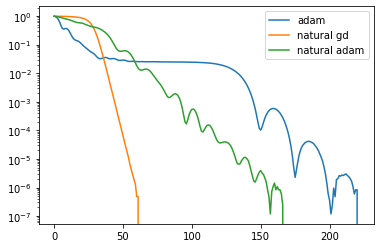

In [7]:
plt.plot(loss_history_adam, label='adam')
plt.plot(loss_history_ngd, label='natural gd')
plt.plot(loss_history_nadam, label='natural adam')
plt.legend()
plt.yscale('log')

# 2-qubit systematically

Let us start small. The first goal is to reliably identify 0, 1, 2, or 3 CNOT unitaries.

In [149]:
num_qubits = 2
u_sample = []
for d in range(4):
    anz = Ansatz(num_qubits, 'cz', placements=fill_layers(sequ_layer(num_qubits), d))
    angles = random_angles(anz.num_angles, key=random.PRNGKey(d))
    u_sample.append(anz.unitary(angles))

Here is an ansatz that we going to teach this.

In [158]:
num_qubits = 2
depth = 3
anz = Ansatz(num_qubits, 'cp', placements=fill_layers(sequ_layer(num_qubits), depth))
anz.circuit().draw(output='mpl')

anz_cost = [lambda angs: disc2(anz.unitary(angs), u_sample[i]) for i in range(4)]

Now we try different methods.

## N=3

In [161]:
cp_cost_func = lambda angs: cp_loss(anz_cost[3], angs, anz.cp_mask, reg=0.01) 
angles_history_gd, loss_hisotory_gd = gradient_descent_minimize(cp_cost_func,
                                                                anz.num_angles)

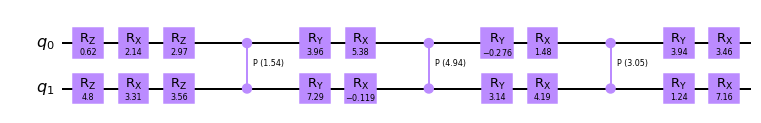

In [163]:
anz.circuit(angles_history_gd[-1]).draw(output='mpl')

In [164]:
cp_cost_func = lambda angs: cp_loss(anz_cost[3], angs, anz.cp_mask, reg=0.01) 
angles_history_adam, loss_hisotory_adam = optax_minimize(cp_cost_func,
                                                         anz.num_angles, 
                                                         optax.adam(0.1))

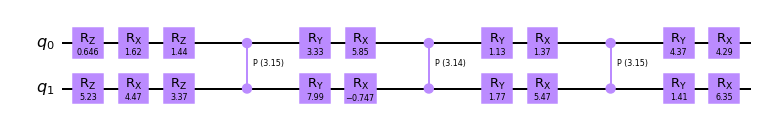

In [165]:
anz.circuit(angles_history_adam[-1]).draw(output='mpl')

In [191]:
cp_cost_func = lambda angs: cp_loss(anz_cost[3], angs, anz.cp_mask, reg=0.01) 
preconditioner = plain_natural_preconditioner(anz.unitary)
angles_history_ngd, loss_hisotory_ngd = gradient_descent_minimize(cp_cost_func,
                                                                  anz.num_angles, 
                                                                  preconditioner_func=preconditioner,
                                                                  learning_rate=0.01)

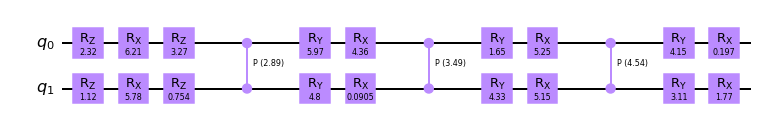

In [187]:
anz.circuit(angles_history_ngd[-1] % (2*jnp.pi)).draw(output='mpl')

In [196]:
cp_cost_func = lambda angs: cp_loss(anz_cost[3], angs, anz.cp_mask, reg=0.01) 
preconditioner = plain_natural_preconditioner(anz.unitary)
angles_history_nadam, loss_hisotory_nadam = optax_minimize(cp_cost_func,
                                                       anz.num_angles, 
                                                       optax.adam(0.05),
                                                       preconditioner_func=preconditioner,
                                                       )

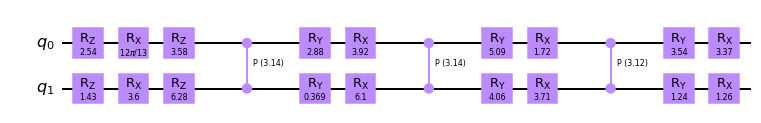

In [198]:
anz.circuit(angles_history_nadam[-1] % (2*jnp.pi)).draw(output='mpl')

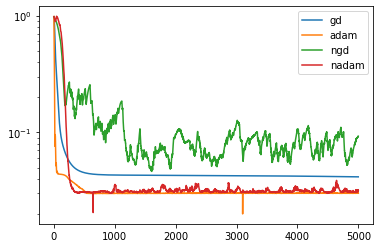

In [197]:
plt.plot(loss_hisotory_gd, label='gd')
plt.plot(loss_hisotory_adam, label='adam')
plt.plot(loss_hisotory_ngd, label='ngd')
plt.plot(loss_hisotory_nadam, label='nadam')
plt.yscale('log')
plt.legend()

# 3-qubit Toffoli

Learning 3-qubits Toffoli with predefine pattern of 2-qubit gates. Note that the problem is not trivial because without CP gates the learning is about 80% likely to be stuck in local minimum. Let's see if we can do better with CP regularization.

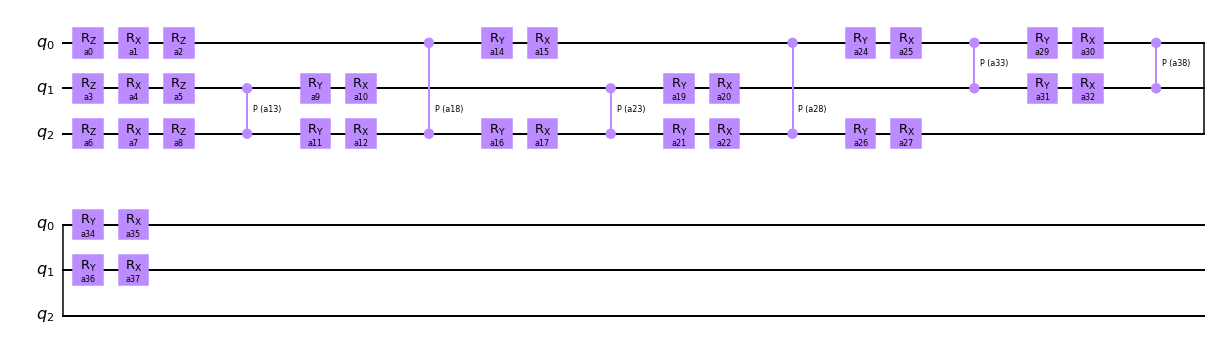

In [3]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
u_toff3 = Operator(qc.reverse_bits()).data

placements_toff3 = [[1, 2], [0, 2], [1, 2], [0, 2], [0, 1], [0, 1]]
anz_toff3 = Ansatz(3, 'cp', placements={'free': placements_toff3})

anz_toff3.circuit().draw(output='mpl')

In [46]:
%%time
best_angles_hist_nadam, success_hist_nadam = success_rate(anz_toff3, u_toff3, 6, method='natural adam', t=0.15, num_samples=30)

CPU times: user 12min 1s, sys: 1min 49s, total: 13min 51s
Wall time: 10min 32s


In [48]:
sum(success_hist_nadam)/len(success_hist_nadam)

0.6333333333333333

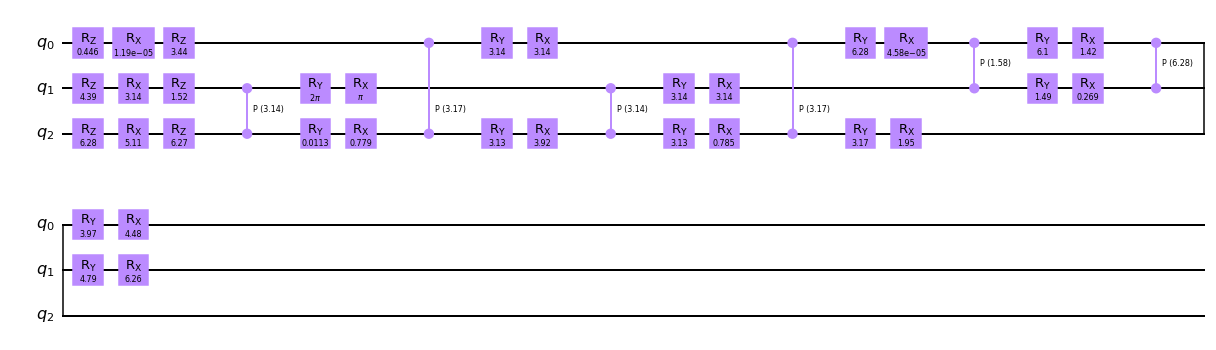

In [50]:
anz_toff3.circuit(best_angles_hist_nadam[-1] % (2*jnp.pi)).draw(output='mpl')

In [56]:
anz_toff3_cz = Ansatz(3, 'cz', placements={'free':[[1,2],[0,2],[1,2],[0,2],[0,1],[0,1]]})

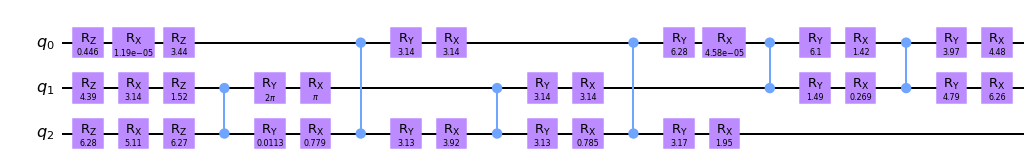

In [60]:
anz_toff3_cz.circuit(test_angles).draw(output='mpl')

In [91]:
_, loss_hist = anz_toff3_cz.learn(u_toff3, initial_params=test_angles)

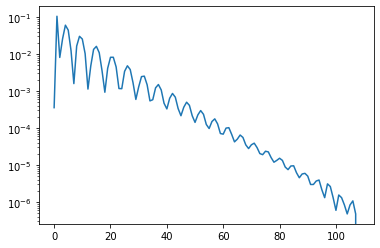

In [92]:
plt.plot(loss_hist)
plt.yscale('log')

In [90]:
test_angles = best_angles_hist_nadam[-13]*(1-anz_toff3.cp_mask)
test_angles = test_angles[test_angles!=0] % (2*jnp.pi)

Let's see if the hyperparameters we chose for Toffoli gate generalize to other 3-qubit 6 CNOT gates.

In [116]:
%%time

placement0 = sequ_layer(3) * 2
placement1 = [[0, 2], [1, 2], [0, 1], [1, 2], [0, 1], [1, 2]]
placement2 = [[0, 1], [0, 2], [0, 1], [1, 2], [0, 1], [0, 2]]

placement_list = [placement0, placement1, placement2]

t=0.15
num_samples=30

best_angles_total = []
success_hist_total = []
for i in [0, 1, 2]:
    anz_cz = Ansatz(3, 'cz', placements={'free': placement_list[i]})
    u_target = anz_cz.unitary(random_angles(anz_cz.num_angles, key=random.PRNGKey(i)))

    anz_cp = Ansatz(3, 'cp', placements={'free': placement_list[i]})
    best_angles_hist, success_hist = success_rate(anz_cp, u_target, 6, 'natural adam', t=t, num_samples=num_samples)
    best_angles_total.append(best_angles_hist)
    success_hist_total.append(success_hist)
    success_prob = sum(success_hist)/len(success_hist)
    print('For unitary {} success rate is {}'.format(i, success_prob))

For unitary 0 success rate is 0.36666666666666664
For unitary 1 success rate is 0.3333333333333333
For unitary 2 success rate is 0.4666666666666667
CPU times: user 32min 32s, sys: 4min 35s, total: 37min 8s
Wall time: 28min 27s


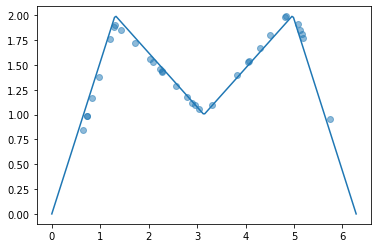

In [21]:
plot_cp_angles(angles_target, h=2, t=0.15)

In [22]:
%%time
t = 0.15
placements = fill_layers(sequ_layer(3), 6)

anz_cz = Ansatz(3, 'cz', placements=placements)
angles_target = random_angles(anz_cz.num_angles, key=random.PRNGKey(0))
u_target = anz_cz.unitary(angles_target)

anz_cp = Ansatz(3, 'cp', placements=placements)
angles_hist, loss_hist, disc_hist, penalty_hist = anz_cp.learn(u_target, method='natural adam', cp_penalty=True, t=t)
best_angles = angles_hist[jnp.argmin(loss_hist)]

CPU times: user 41.4 s, sys: 15.7 s, total: 57.1 s
Wall time: 27.8 s


6.0


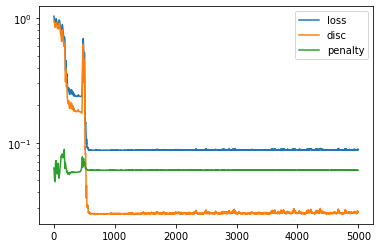

In [23]:
print(count_cnots(best_angles*anz_cp.cp_mask))
plt.plot(loss_hist, label='loss')
plt.plot(disc_hist, label='disc')
plt.plot(penalty_hist, label='penalty')
plt.yscale('log')
plt.legend()

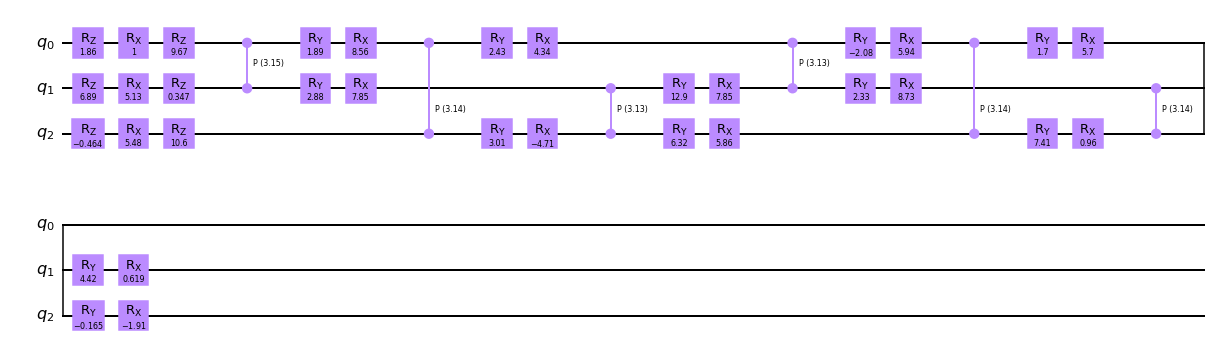

In [24]:
anz_cp.circuit(best_angles).draw(output='mpl')

In [118]:
%%time

placement0 = sequ_layer(3) * 2
placement1 = [[0, 2], [1, 2], [0, 1], [1, 2], [0, 1], [1, 2]]
placement2 = [[0, 1], [0, 2], [0, 1], [1, 2], [0, 1], [0, 2]]

placement_list = [placement0, placement1, placement2]

t=0.15
num_samples=40

best_angles_total = []
success_hist_total = []
for i in [0, 1, 2]:
    anz_cz = Ansatz(3, 'cz', placements={'free': placement_list[i]})
    u_target = anz_cz.unitary(random_angles(anz_cz.num_angles, key=random.PRNGKey(i+10)))

    anz_cp = Ansatz(3, 'cp', placements={'free': placement_list[i]})
    best_angles_hist, success_hist = success_rate(anz_cp, u_target, 6, 'natural adam', t=t, num_samples=num_samples)
    best_angles_total.append(best_angles_hist)
    success_hist_total.append(success_hist)
    success_prob = sum(success_hist)/len(success_hist)
    print('For unitary {} success rate is {}'.format(i, success_prob))

For unitary 0 success rate is 0.075
For unitary 1 success rate is 0.45
For unitary 2 success rate is 0.1
CPU times: user 43min 25s, sys: 6min 6s, total: 49min 31s
Wall time: 37min 56s


In [119]:
%%time

placement0 = sequ_layer(3) * 2
placement1 = [[0, 2], [1, 2], [0, 1], [1, 2], [0, 1], [1, 2]]
placement2 = [[0, 1], [0, 2], [0, 1], [1, 2], [0, 1], [0, 2]]

placement_list = [placement0, placement1, placement2]

t=0.20
num_samples=40

best_angles_total = []
success_hist_total = []
for i in [0, 1, 2]:
    anz_cz = Ansatz(3, 'cz', placements={'free': placement_list[i]})
    u_target = anz_cz.unitary(random_angles(anz_cz.num_angles, key=random.PRNGKey(i+10)))

    anz_cp = Ansatz(3, 'cp', placements={'free': placement_list[i]})
    best_angles_hist, success_hist = success_rate(anz_cp, u_target, 6, 'natural adam', t=t, num_samples=num_samples)
    best_angles_total.append(best_angles_hist)
    success_hist_total.append(success_hist)
    success_prob = sum(success_hist)/len(success_hist)
    print('For unitary {} success rate is {}'.format(i, success_prob))

For unitary 0 success rate is 0.05
For unitary 1 success rate is 0.3
For unitary 2 success rate is 0.175
CPU times: user 43min 53s, sys: 6min 6s, total: 50min
Wall time: 38min 13s


In [117]:
%%time

placement0 = sequ_layer(3) * 2
placement1 = [[0, 2], [1, 2], [0, 1], [1, 2], [0, 1], [1, 2]]
placement2 = [[0, 1], [0, 2], [0, 1], [1, 2], [0, 1], [0, 2]]

placement_list = [placement0, placement1, placement2]

t=0.20
num_samples=30

best_angles_total = []
success_hist_total = []
for i in [0, 1, 2]:
    anz_cz = Ansatz(3, 'cz', placements={'free': placement_list[i]})
    u_target = anz_cz.unitary(random_angles(anz_cz.num_angles, key=random.PRNGKey(i)))

    anz_cp = Ansatz(3, 'cp', placements={'free': placement_list[i]})
    best_angles_hist, success_hist = success_rate(anz_cp, u_target, 6, 'natural adam', t=t, num_samples=num_samples)
    best_angles_total.append(best_angles_hist)
    success_hist_total.append(success_hist)
    success_prob = sum(success_hist)/len(success_hist)
    print('For unitary {} success rate is {}'.format(i, success_prob))

For unitary 0 success rate is 0.06666666666666667
For unitary 1 success rate is 0.26666666666666666
For unitary 2 success rate is 0.5
CPU times: user 32min 48s, sys: 4min 39s, total: 37min 28s
Wall time: 28min 39s


In [ ]:
%%time

t=0.15
num_samples=30

best_angles_total = []
success_hist_total = []
for i in range(15):
    placements = fill_layers(sequ_layer(3), i)
    anz_cz = Ansatz(3, 'cz', placements=placements)
    u_target = anz_cz.unitary(random_angles(anz_cz.num_angles, key=random.PRNGKey(i)))

    anz_cp = Ansatz(3, 'cp', placements=placements)
    best_angles_hist, success_hist = success_rate(anz_cp, u_target, i, 'natural adam', t=t, num_samples=num_samples)
    best_angles_total.append(best_angles_hist)
    success_hist_total.append(success_hist)
    success_prob = sum(success_hist)/len(success_hist)
    print('For unitary {} success rate is {}'.format(i, success_prob))

For unitary 0 success rate is 1.0
For unitary 1 success rate is 1.0
For unitary 2 success rate is 1.0
For unitary 3 success rate is 0.9333333333333333
For unitary 4 success rate is 0.3


In [5]:
%%time

t=0.15
num_samples=30

best_angles_total = []
success_hist_total = []
for i in range(5):
    placements = fill_layers(sequ_layer(3), i)
    anz_cz = Ansatz(3, 'cz', placements=placements)
    u_target = anz_cz.unitary(random_angles(anz_cz.num_angles, key=random.PRNGKey(i)))

    anz_cp = Ansatz(3, 'cp', placements=placements)
    best_angles_hist, success_hist = success_rate(anz_cp, u_target, i, 'natural adam', t=t, num_samples=num_samples)
    best_angles_total.append(best_angles_hist)
    success_hist_total.append(success_hist)
    success_prob = sum(success_hist)/len(success_hist)
    print('For unitary {} success rate is {}'.format(i, success_prob))

For unitary 0 success rate is 1.0
For unitary 1 success rate is 1.0
For unitary 2 success rate is 1.0
For unitary 3 success rate is 0.9333333333333333
For unitary 4 success rate is 0.3
CPU times: user 25min 37s, sys: 4min 33s, total: 30min 10s
Wall time: 21min 50s


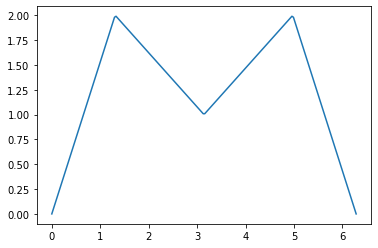

In [26]:
a_sweep = jnp.linspace(0, 2*jnp.pi, 200)
plt.plot(a_sweep, cp_penalty_linear(a_sweep, 2, 0.15))

# Learning in the difficult region

In [53]:
%%time
placements = fill_layers(sequ_layer(3), 9)
anz_cz = Ansatz(3, 'cz', placements=placements)
target_angles = random_angles(anz_cz.num_angles, key=random.PRNGKey(1))
u_target = anz_cz.unitary(target_angles)

anz_cp = Ansatz(3, 'cp', placements=placements)
angles_hist, loss_hist, disc_hist, penalty_hist = anz_cp.learn(u_target, 
                                      method='natural adam', 
                                      cp_penalty=True, 
                                      h=2, 
                                      t=0.15)

best_angles = angles_hist[jnp.argmin(loss_hist)]

CPU times: user 47.4 s, sys: 19 s, total: 1min 6s
Wall time: 29.6 s


14.0


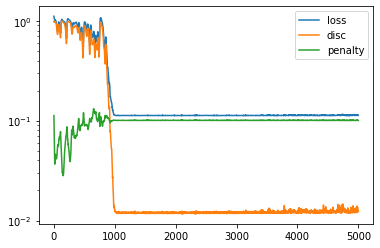

In [54]:
print(count_cnots(best_angles*anz_cp.cp_mask))
plt.plot(loss_hist, label='loss')
plt.plot(disc_hist, label='disc')
plt.plot(penalty_hist, label='penalty')
plt.yscale('log')
plt.legend()

In [55]:
%%time
best_angles_hist, success_hist = success_rate(anz_cp, u_target, 9, 'natural adam', t=t, num_samples=100)

CPU times: user 38min 25s, sys: 6min 54s, total: 45min 20s
Wall time: 31min 38s


In [56]:
sum(success_hist)/len(success_hist)

0.0

In [58]:
%%time
best_angles_hist, success_hist = success_rate(anz_cp, u_target, 9, 'natural gd', t=t, num_samples=100)

CPU times: user 38min 50s, sys: 5min 53s, total: 44min 44s
Wall time: 32min 43s


In [59]:
sum(success_hist)/len(success_hist)

0.0

In [60]:
%%time
best_angles_hist, success_hist = success_rate(anz_cp, u_target, 9, 'adam', t=t, num_samples=100)

CPU times: user 16min 51s, sys: 7.4 s, total: 16min 58s
Wall time: 16min 34s


In [61]:
sum(success_hist)/len(success_hist)

0.0

In [5]:
%%time
placements = fill_layers(sequ_layer(3), 8)
anz_cz = Ansatz(3, 'cz', placements=placements)
target_angles = random_angles(anz_cz.num_angles, key=random.PRNGKey(1))
u_target = anz_cz.unitary(target_angles)

t=0.15
anz_cp = Ansatz(3, 'cp', placements=fill_layers(sequ_layer(3), 10))

CPU times: user 841 ms, sys: 5.87 ms, total: 846 ms
Wall time: 835 ms


In [6]:
%%time
best_angles_hist, success_hist = success_rate(anz_cp, u_target, 10, 'adam', t=t, num_samples=50)

CPU times: user 9min 5s, sys: 3.9 s, total: 9min 9s
Wall time: 8min 56s


In [7]:
sum(success_hist)

0

Not successfull yet.

# Learning with extra gates

Works fine for toffoli 3.

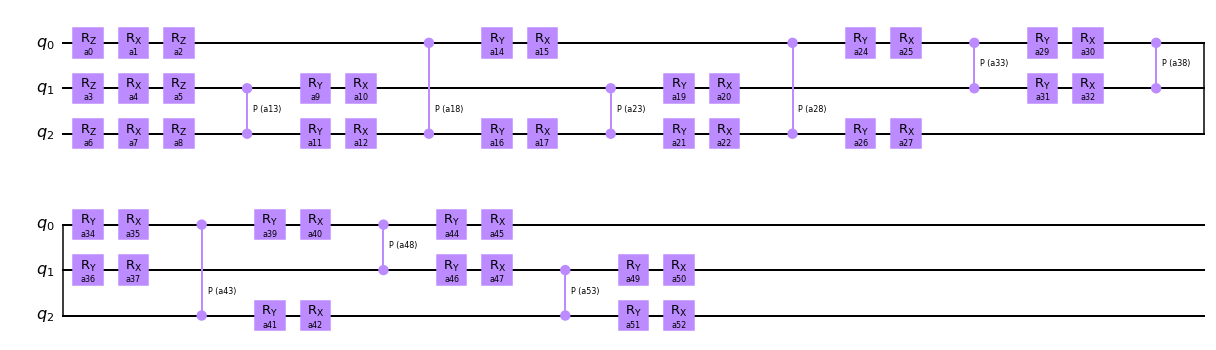

In [8]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
u_toff3 = Operator(qc.reverse_bits()).data

placements_toff3 = [[1, 2], [0, 2], [1, 2], [0, 2], [0, 1], [0, 1]]
extra_placements = [[0, 2], [0, 1], [1, 2]]

anz_toff3 = Ansatz(3, 'cp', placements={'free': placements_toff3+extra_placements})

anz_toff3.circuit().draw(output='mpl')

In [83]:
%%time
initial_angles = random_cp_angles(anz_toff3.num_angles, anz_toff3.cp_mask, key=random.PRNGKey(10))
res = anz_toff3.learn(u_toff3, method='natural adam', cp_penalty=True, t=0.15, learning_rate=0.025, r=0.0005, initial_params=initial_angles)
angs_hist, loss_hist, disc_hist, penalty_hist = res

CPU times: user 1min 1s, sys: 21.1 s, total: 1min 22s
Wall time: 41.6 s


cnot count: 6.0
fidelity at this count: 8.821487426757812e-06


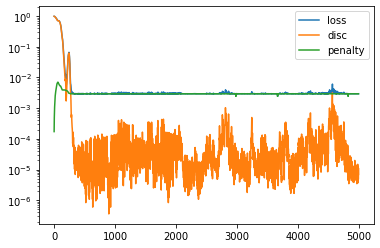

In [84]:
best_angles, best_cp_angles = report_cp_learning(res, cp_mask=anz_toff3.cp_mask)

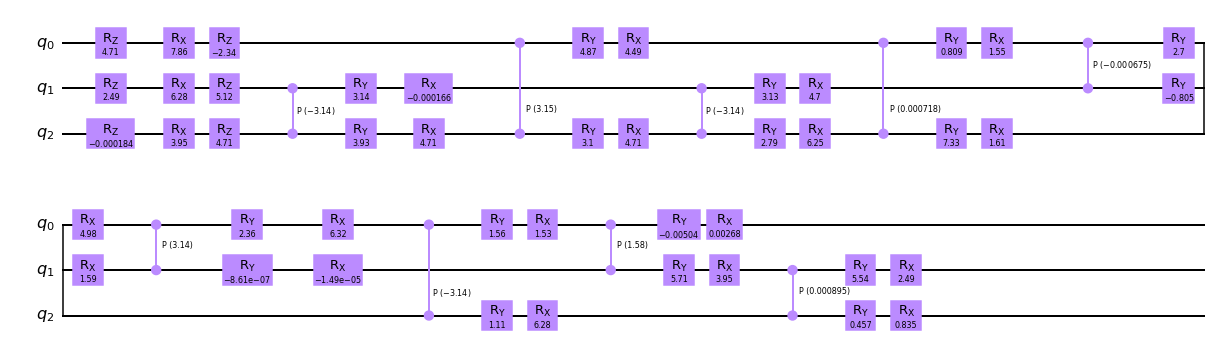

In [68]:
anz_toff3.circuit(best_angles).draw(output='mpl')

In [3]:
anz_cz = Ansatz(3, 'cz', placements=fill_layers(sequ_layer(3), 8))
angles_target = random_angles(anz_cz.num_angles, key=random.PRNGKey(123))
u_target = anz_cz.unitary(angles_target)

anz_cp = Ansatz(3, 'cp', placements=fill_layers(sequ_layer(3), 14))

cnot count: 18.0
fidelity at this count: 0.005213022232055664
CPU times: user 17.4 s, sys: 346 ms, total: 17.8 s
Wall time: 16.3 s


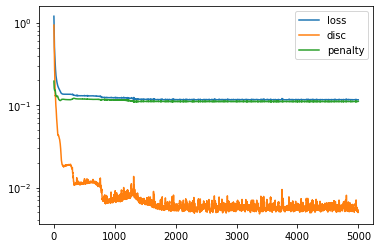

In [43]:
%%time
initial_angles = random_cp_angles(anz_cp.num_angles, anz_cp.cp_mask, key=random.PRNGKey(2))
initial_angles = initial_angles+jnp.pi*jnp.ones(len(initial_angles))*anz_cp.cp_mask
initial_angles = random_angles(anz_cp.num_angles, key=random.PRNGKey(2))

res = anz_cp.learn(u_target, 
                   method='adam', 
                   cp_penalty=True, 
                   xmax=1.5, 
                   ymax=2,
                   plato=0.01,
                   learning_rate=0.1, 
                   r=0.01, 
                   initial_params=initial_angles, 
                   num_iterations=5000)

angs_hist, loss_hist, disc_hist, penalty_hist = res
best_angles, best_cp_angles = report_cp_learning(res, cp_mask=anz_cp.cp_mask)

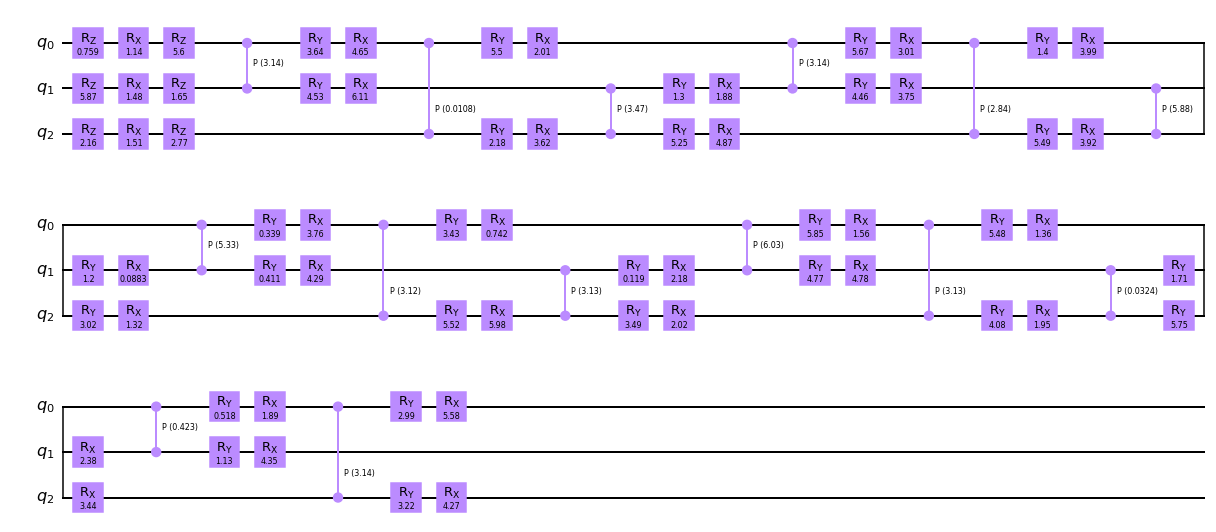

In [44]:
anz_cp.circuit(best_angles % (2*jnp.pi)).draw(output='mpl')

In [45]:
anz_3 = Ansatz(3, 'cz', placements=fill_layers(sequ_layer(3), 10))
ah, lh = anz_3.learn(u_target)

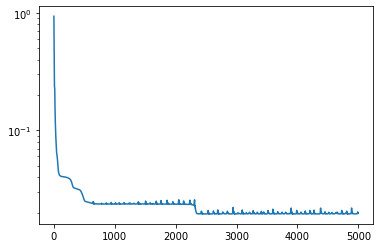

In [38]:
plt.plot(lh)
plt.yscale('log')